In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, ConfusionMatrixDisplay
import pickle

In [ ]:
df = pd.read_csv(r"/content/transaction_dataset.csv", index_col=0)
print(df.shape)
df.head()

(9841, 50)


,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [ ]:
# Ommit first two columns (Index, Adress)
df = df.iloc[:,2:]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9841 entries, 0 to 9840
Data columns (total 48 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   FLAG                                                  9841 non-null   int64  
 1   Avg min between sent tnx                              9841 non-null   float64
 2   Avg min between received tnx                          9841 non-null   float64
 3   Time Diff between first and last (Mins)               9841 non-null   float64
 4   Sent tnx                                              9841 non-null   int64  
 5   Received Tnx                                          9841 non-null   int64  
 6   Number of Created Contracts                           9841 non-null   int64  
 7   Unique Received From Addresses                        9841 non-null   int64  
 8   Unique Sent To Addresses                              9841 non-

In [ ]:
categories = df.select_dtypes('O').columns.astype('category')
df[categories]

,ERC20 most sent token type,ERC20_most_rec_token_type
0,Cofoundit,Numeraire
1,Livepeer Token,Livepeer Token
2,NaN,XENON
3,Raiden,XENON
4,StatusNetwork,EOS
...,...,...
9836,,GSENetwork
9837,,Blockwell say NOTSAFU
9838,,Free BOB Tokens - BobsRepair.com
9839,NaN,NaN


In [ ]:
for i in df[categories].columns:
  print(f'The categorical column --{i}-- has --{len(df[i].value_counts())}-- unique values')

The categorical column -- ERC20 most sent token type-- has --304-- unique values
The categorical column -- ERC20_most_rec_token_type-- has --466-- unique values


In [ ]:
numericals = df.select_dtypes(include=['float','int']).columns
df[numericals].describe()

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name
count,9841.000000,9841.000000,9841.000000,9.841000e+03,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,...,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9012.0,9012.0,9012.0,9012.000000,9012.000000
mean,0.221421,5086.878721,8004.851184,2.183333e+05,115.931714,163.700945,3.729702,30.360939,25.840159,43.845153,...,1.252524e+08,4.346203e+06,1.174126e+04,1.303594e+07,6.318389e+06,0.0,0.0,0.0,1.384931,4.826676
std,0.415224,21486.549974,23081.714801,3.229379e+05,757.226361,940.836550,141.445583,298.621112,263.820410,325.929139,...,1.053741e+10,2.141192e+08,1.053567e+06,1.179905e+09,5.914764e+08,0.0,0.0,0.0,6.735121,16.678607
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.169300e+02,1.000000,1.000000,0.000000,1.000000,1.000000,0.001000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
50%,0.000000,17.340000,509.770000,4.663703e+04,3.000000,4.000000,0.000000,2.000000,2.000000,0.095856,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,1.000000
75%,0.000000,565.470000,5480.390000,3.040710e+05,11.000000,27.000000,0.000000,5.000000,3.000000,2.000000,...,9.900000e+01,2.946467e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,2.000000
max,1.000000,430287.670000,482175.490000,1.954861e+06,10000.000000,10000.000000,9995.000000,9999.000000,9287.000000,10000.000000,...,1.000000e+12,1.724181e+10,1.000000e+08,1.120000e+11,5.614756e+10,0.0,0.0,0.0,213.000000,737.000000


In [ ]:
df[numericals].var()

,0
FLAG,1.724110e-01
Avg min between sent tnx,4.616718e+08
Avg min between received tnx,5.327656e+08
Time Diff between first and last (Mins),1.042889e+11
Sent tnx,5.733918e+05
Received Tnx,8.851734e+05
Number of Created Contracts,2.000685e+04
Unique Received From Addresses,8.917457e+04
Unique Sent To Addresses,6.960121e+04
min value received,1.062298e+05


FLAG
0    7662
1    2179
Name: count, dtype: int64


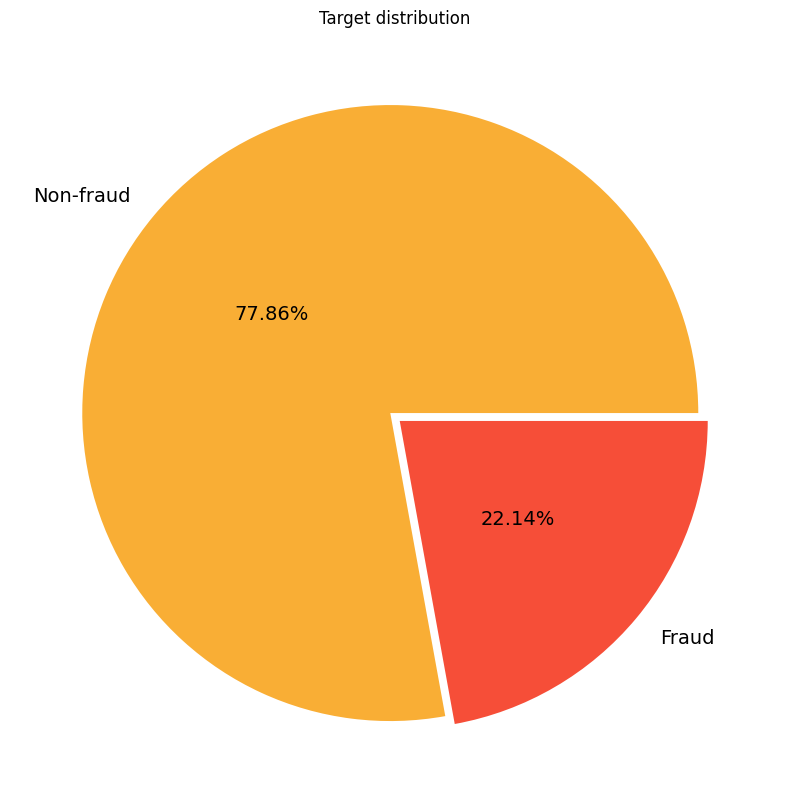

In [ ]:
print(df['FLAG'].value_counts())

pie, ax = plt.subplots(figsize=[15,10])
labels = ['Non-fraud', 'Fraud']
colors = ['#f9ae35', '#f64e38']
plt.pie(x = df['FLAG'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors)
plt.title('Target distribution')
plt.show()

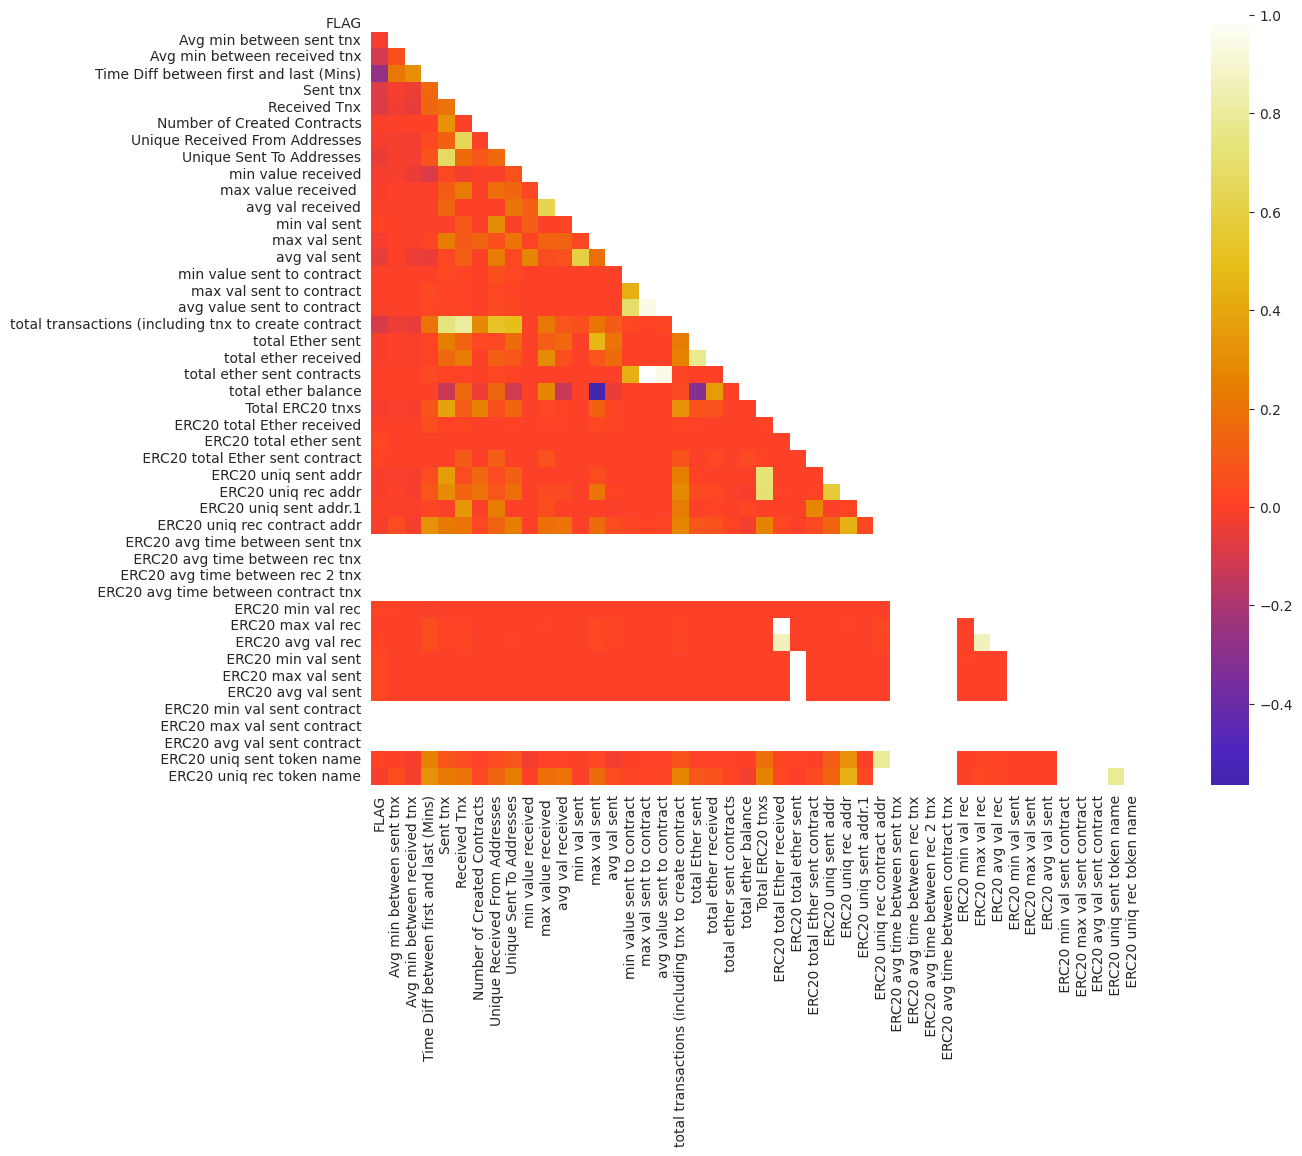

In [ ]:
# Correlation matrix
corr = df.select_dtypes(include=np.number).corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
  fig, ax = plt.subplots(figsize=(18,10))
  sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, square=True)

# **Data Cleaning**

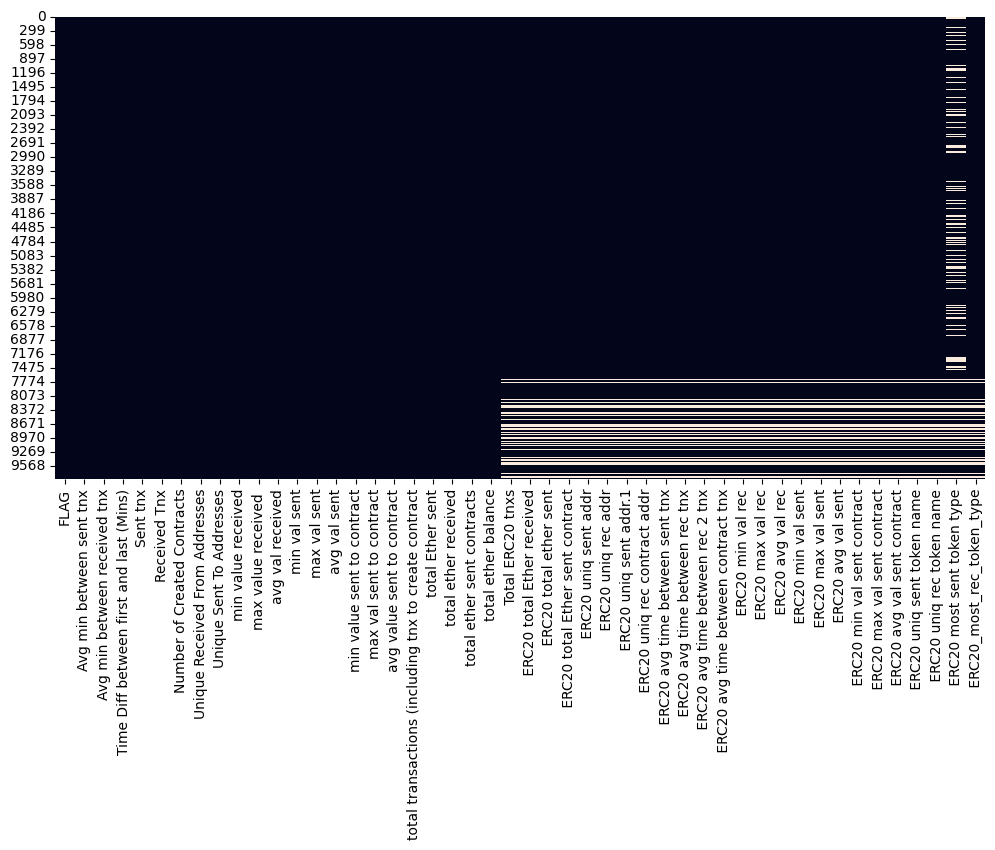

In [ ]:
# Visualize missings pattern of the dataframe
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [ ]:
# Drop the two categorical features
df.drop(df[categories], axis=1, inplace=True)

In [ ]:
# Replace missings of numerical variables with median
df.fillna(df.median(), inplace=True)

(9841, 46)


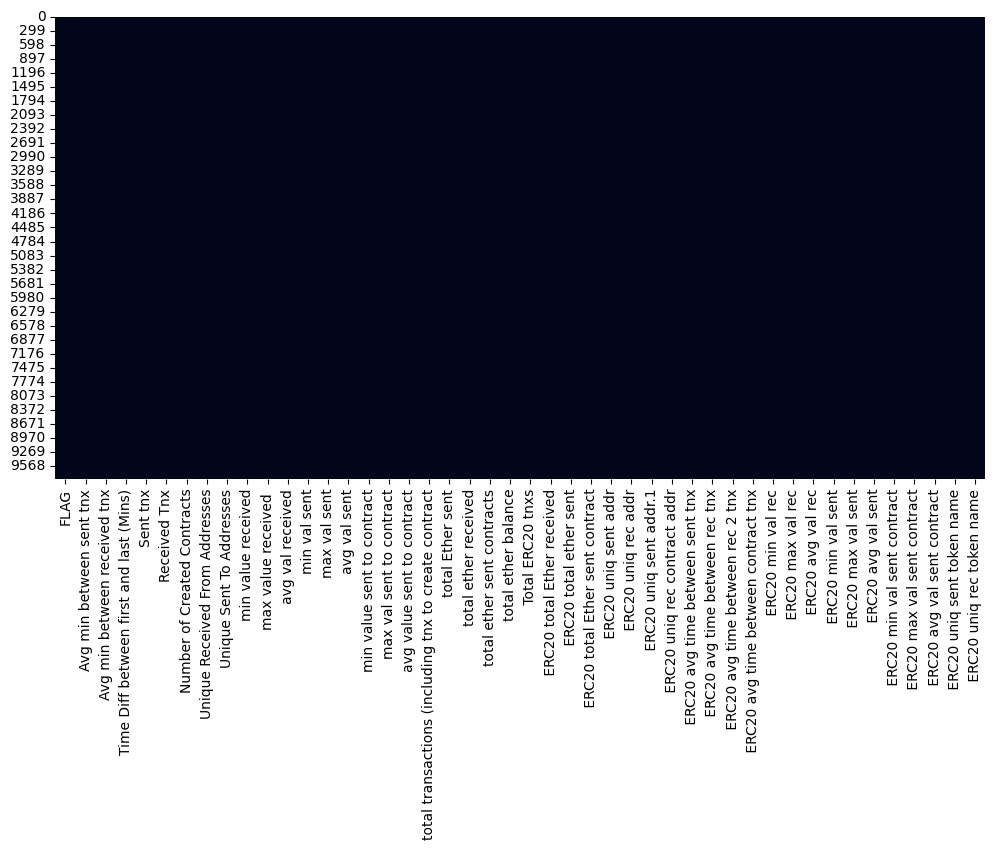

In [ ]:
# Visualize missings pattern of the dataframe
print(df.shape)
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [ ]:
# Filtering the features with 0 variance
no_var = df.var() == 0
print(df.var()[no_var])
print('\n')

# Drop features with 0 variance --- these features will not help in the performance of the model
df.drop(df.var()[no_var].index, axis = 1, inplace = True)
print(df.var())
print(df.shape)

ERC20 avg time between sent tnx        0.0
ERC20 avg time between rec tnx         0.0
ERC20 avg time between rec 2 tnx       0.0
ERC20 avg time between contract tnx    0.0
ERC20 min val sent contract            0.0
ERC20 max val sent contract            0.0
ERC20 avg val sent contract            0.0
dtype: float64


FLAG                                                    1.724110e-01
Avg min between sent tnx                                4.616718e+08
Avg min between received tnx                            5.327656e+08
Time Diff between first and last (Mins)                 1.042889e+11
Sent tnx                                                5.733918e+05
Received Tnx                                            8.851734e+05
Number of Created Contracts                             2.000685e+04
Unique Received From Addresses                          8.917457e+04
Unique Sent To Addresses                                6.960121e+04
min value received                                      1.062

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9841 entries, 0 to 9840
Data columns (total 39 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   FLAG                                                  9841 non-null   int64  
 1   Avg min between sent tnx                              9841 non-null   float64
 2   Avg min between received tnx                          9841 non-null   float64
 3   Time Diff between first and last (Mins)               9841 non-null   float64
 4   Sent tnx                                              9841 non-null   int64  
 5   Received Tnx                                          9841 non-null   int64  
 6   Number of Created Contracts                           9841 non-null   int64  
 7   Unique Received From Addresses                        9841 non-null   int64  
 8   Unique Sent To Addresses                              9841 non-

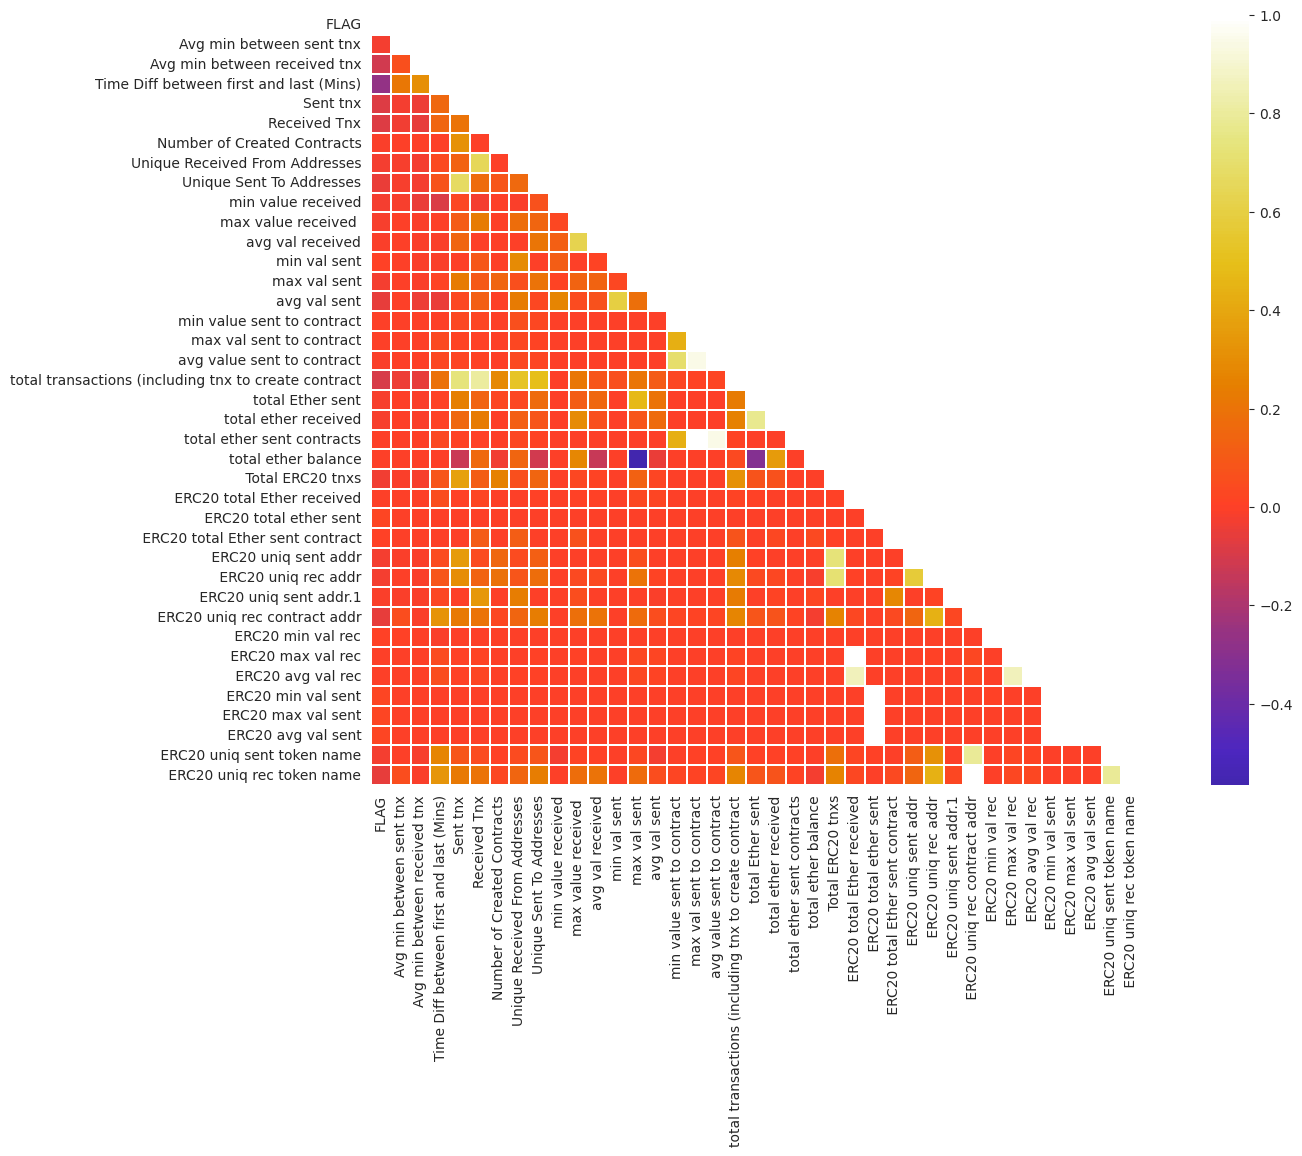

In [ ]:
# Recheck the Correlation matrix
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
  fig, ax = plt.subplots(figsize=(18,10))
  sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, linewidths=0.1, square=True)

In [ ]:
drop = ['total transactions (including tnx to create contract', 'total ether sent contracts', 'max val sent to contract', ' ERC20 avg val rec',
        ' ERC20 avg val rec',' ERC20 max val rec', ' ERC20 min val rec', ' ERC20 uniq rec contract addr', 'max val sent', ' ERC20 avg val sent',
        ' ERC20 min val sent', ' ERC20 max val sent', ' Total ERC20 tnxs', 'avg value sent to contract', 'Unique Sent To Addresses',
        'Unique Received From Addresses', 'total ether received', ' ERC20 uniq sent token name', 'min value received', 'min val sent', ' ERC20 uniq rec addr' ]
df.drop(drop, axis=1, inplace=True)

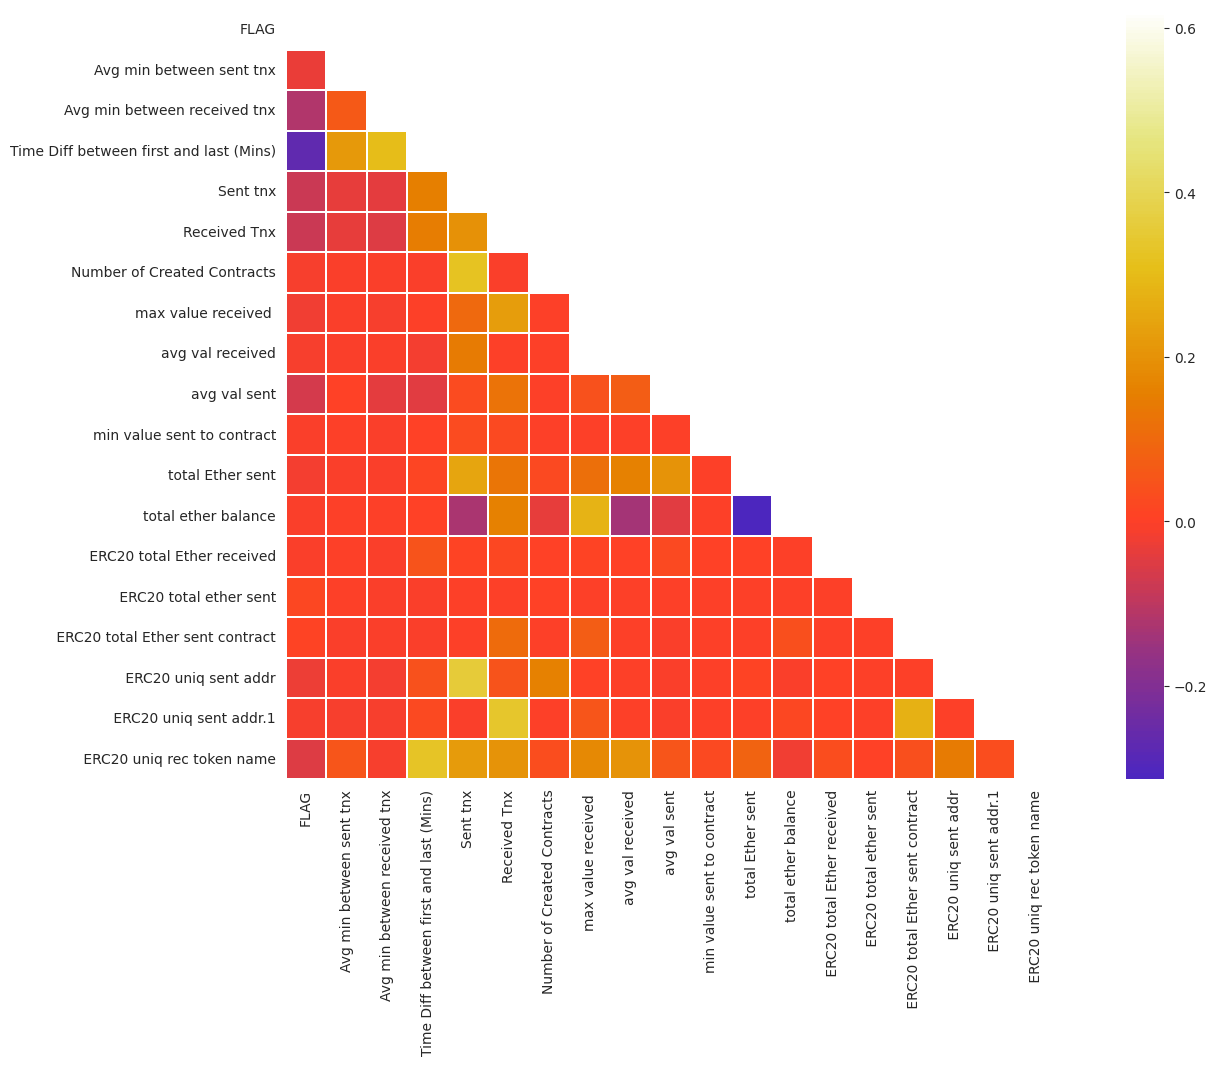

In [ ]:
# Recheck the Correlation matrix
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
  fig, ax = plt.subplots(figsize=(18,10))
  sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, linewidths=0.1, square=True)

In [ ]:
columns = df.columns
columns

Index(['FLAG', 'Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'max value received ',
       'avg val received', 'avg val sent', 'min value sent to contract',
       'total Ether sent', 'total ether balance',
       ' ERC20 total Ether received', ' ERC20 total ether sent',
       ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr',
       ' ERC20 uniq sent addr.1', ' ERC20 uniq rec token name'],
      dtype='object')

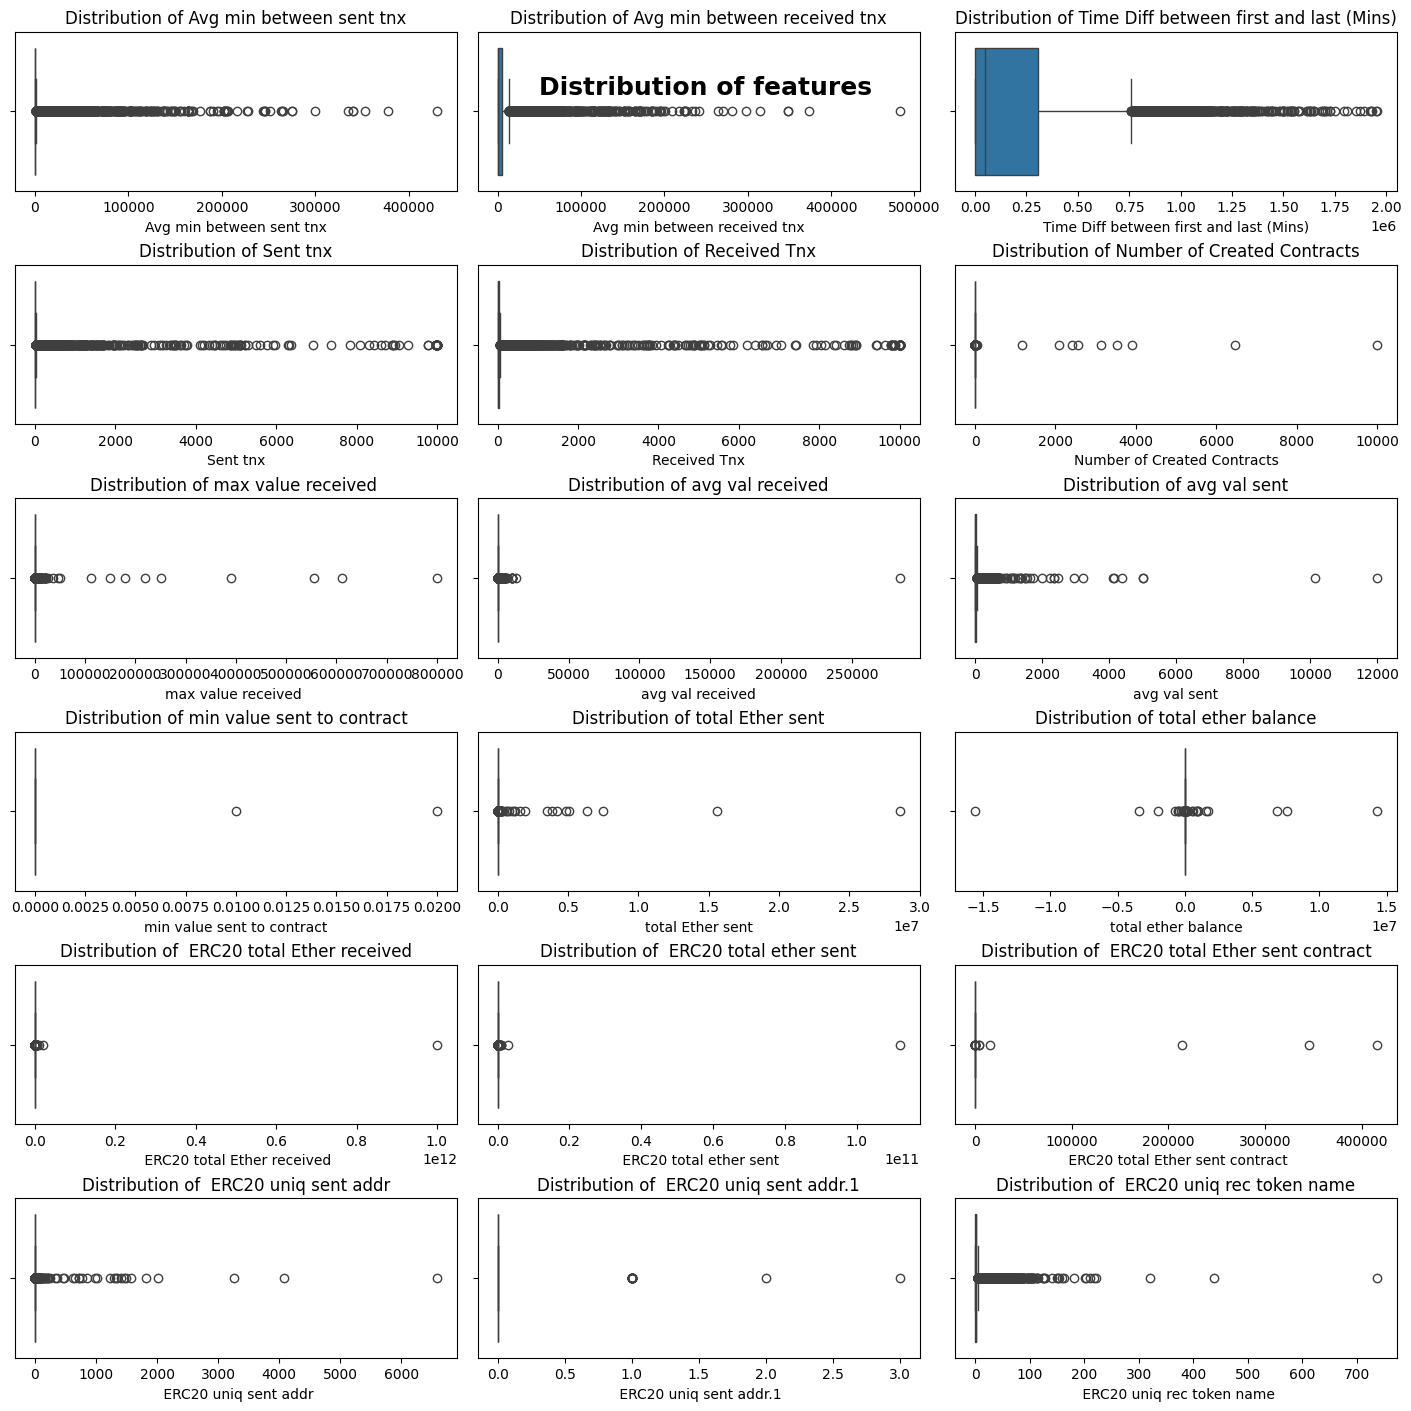

In [ ]:
# Investigate the distribution of our features using boxplots
b=20

fig, axes = plt.subplots(6, 3, figsize=(14, 14), constrained_layout =True)
plt.subplots_adjust(wspace = 0.5, hspace=0.8)
plt.suptitle("Distribution of features",y=0.95, size=18, weight='bold')

ax = sns.boxplot(ax = axes[0,0], data=df, x=columns[1])
ax.set_title(f'Distribution of {columns[1]}')

ax1 = sns.boxplot(ax = axes[0,1], data=df, x=columns[2])
ax1.set_title(f'Distribution of {columns[2]}')

ax2 = sns.boxplot(ax = axes[0,2], data=df, x=columns[3])
ax2.set_title(f'Distribution of {columns[3]}')

ax3 = sns.boxplot(ax = axes[1,0], data=df, x=columns[4])
ax3.set_title(f'Distribution of {columns[4]}')

ax4 = sns.boxplot(ax = axes[1,1], data=df, x=columns[5])
ax4.set_title(f'Distribution of {columns[5]}')

ax5 = sns.boxplot(ax = axes[1,2], data=df, x=columns[6])
ax5.set_title(f'Distribution of {columns[6]}')

ax6 = sns.boxplot(ax = axes[2,0], data=df, x=columns[7])
ax6.set_title(f'Distribution of {columns[7]}')

ax7 = sns.boxplot(ax = axes[2,1], data=df, x=columns[8])
ax7.set_title(f'Distribution of {columns[8]}')

ax8 = sns.boxplot(ax = axes[2,2], data=df, x=columns[9])
ax8.set_title(f'Distribution of {columns[9]}')

ax9 = sns.boxplot(ax = axes[3,0], data=df, x=columns[10])
ax9.set_title(f'Distribution of {columns[10]}')

ax10 = sns.boxplot(ax = axes[3,1], data=df, x=columns[11])
ax10.set_title(f'Distribution of {columns[11]}')

ax11 = sns.boxplot(ax = axes[3,2], data=df, x=columns[12])
ax11.set_title(f'Distribution of {columns[12]}')

ax12 = sns.boxplot(ax = axes[4,0], data=df, x=columns[13])
ax12.set_title(f'Distribution of {columns[13]}')

ax13 = sns.boxplot(ax = axes[4,1], data=df, x=columns[14])
ax13.set_title(f'Distribution of {columns[14]}')

ax14 = sns.boxplot(ax = axes[4,2], data=df, x=columns[15])
ax14.set_title(f'Distribution of {columns[15]}')

ax15 = sns.boxplot(ax = axes[5,0], data=df, x=columns[16])
ax15.set_title(f'Distribution of {columns[16]}')

ax16 = sns.boxplot(ax = axes[5,1], data=df, x=columns[17])
ax16.set_title(f'Distribution of {columns[17]}')

ax17 = sns.boxplot(ax = axes[5,2], data=df, x=columns[18])
ax17.set_title(f'Distribution of {columns[18]}')

plt.show()

In [ ]:
# Some features present a small distribution
for i in df.columns[1:]:
  if len(df[i].value_counts()) < 10:
    print(f'The column {i} has the following distribution: \n{df[i].value_counts()}')
    print('======================================')

The column min value sent to contract has the following distribution: 
min value sent to contract
0.00    9839
0.02       1
0.01       1
Name: count, dtype: int64
The column  ERC20 uniq sent addr.1 has the following distribution: 
 ERC20 uniq sent addr.1
0.0    9813
1.0      26
3.0       1
2.0       1
Name: count, dtype: int64


In [ ]:
drops = ['min value sent to contract', ' ERC20 uniq sent addr.1']
df.drop(drops, axis=1, inplace=True)
print(df.shape)
df.head()

(9841, 17)


,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,max value received,avg val received,avg val sent,total Ether sent,total ether balance,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec token name
0,0,844.26,1093.71,704785.63,721,89,0,45.806785,6.589513,1.200681,865.691093,-279.224419,3.558854e+07,3.560317e+07,0.0,30.0,57.0
1,0,12709.07,2958.44,1218216.73,94,8,0,2.613269,0.385685,0.032844,3.087297,-0.001819,4.034283e+02,2.260809e+00,0.0,1.0,7.0
2,0,246194.54,2434.02,516729.30,2,10,0,1.165453,0.358906,1.794308,3.588616,0.000441,5.215121e+02,0.000000e+00,0.0,0.0,8.0
3,0,10219.60,15785.09,397555.90,25,9,0,500.000000,99.488840,70.001834,1750.045862,-854.646303,1.711105e+04,1.141223e+04,0.0,2.0,11.0
4,0,36.61,10707.77,382472.42,4598,20,1,12.802411,2.671095,0.022688,104.318883,-50.896986,1.628297e+05,1.235399e+05,0.0,4.0,27.0


# Data Preperation

In [ ]:
y = df.iloc[:, 0]
X = df.iloc[:, 1:]
print(X.shape, y.shape)

(9841, 16) (9841,)


In [ ]:
# Split into training (80%) and testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7872, 16) (7872,)
(1969, 16) (1969,)


In [ ]:
# Normalize the training features
norm = PowerTransformer()
norm_train_f = norm.fit_transform(X_train)

In [ ]:
norm_df = pd.DataFrame(norm_train_f, columns=X_train.columns)
norm_df

,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,max value received,avg val received,avg val sent,total Ether sent,total ether balance,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec token name
0,1.294061,1.151313,1.393751,1.591951,1.017881,-0.401539,1.170696,0.988757,0.651223,1.416308,-0.007274,1.815951,2.508169,-0.038483,2.398649,1.831406
1,-1.096066,-1.184221,-1.638410,-1.391726,-1.785005,-0.401539,-1.407378,-1.283886,-1.138468,-1.252291,-0.006836,-0.746114,-0.410600,-0.038483,-0.437145,0.226082
2,-0.006354,0.213137,1.103220,1.970707,1.876994,-0.401539,0.613575,-0.995919,-0.869934,1.171479,-0.006819,-0.746114,-0.410600,-0.038483,-0.437145,-0.994019
3,-1.096066,1.220438,0.195684,-1.391726,-0.618856,2.490307,-0.871196,-0.822389,-1.138468,-1.252291,-0.006832,-0.746114,-0.410600,-0.038483,-0.437145,-0.994019
4,0.628503,-1.121221,-0.904665,-0.206187,-0.618856,-0.401539,0.889875,1.277099,1.332663,0.787323,-0.006836,-0.746114,-0.410600,-0.038483,-0.437145,-0.994019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7867,-1.096066,0.249518,-0.705997,-0.590325,-0.618856,-0.401539,-0.535113,-0.269750,0.183532,-0.463079,-0.006836,-0.746114,-0.410600,-0.038483,-0.437145,0.226082
7868,1.128623,0.633621,0.895636,0.707356,1.432439,-0.401539,0.339924,-0.354586,1.043745,1.010645,-0.006835,1.611838,-0.410600,-0.038483,-0.437145,1.238838
7869,-1.096066,-1.184221,-1.154101,-0.590325,-1.004903,-0.401539,-1.275895,-1.091970,-0.960939,-1.159157,-0.006835,-0.746114,-0.410600,-0.038483,-0.437145,-0.994019
7870,1.385084,0.988959,0.715180,0.707356,0.556810,-0.401539,1.858790,1.531808,1.671553,1.592460,-0.006835,1.514388,-0.410600,-0.038483,-0.437145,1.122262


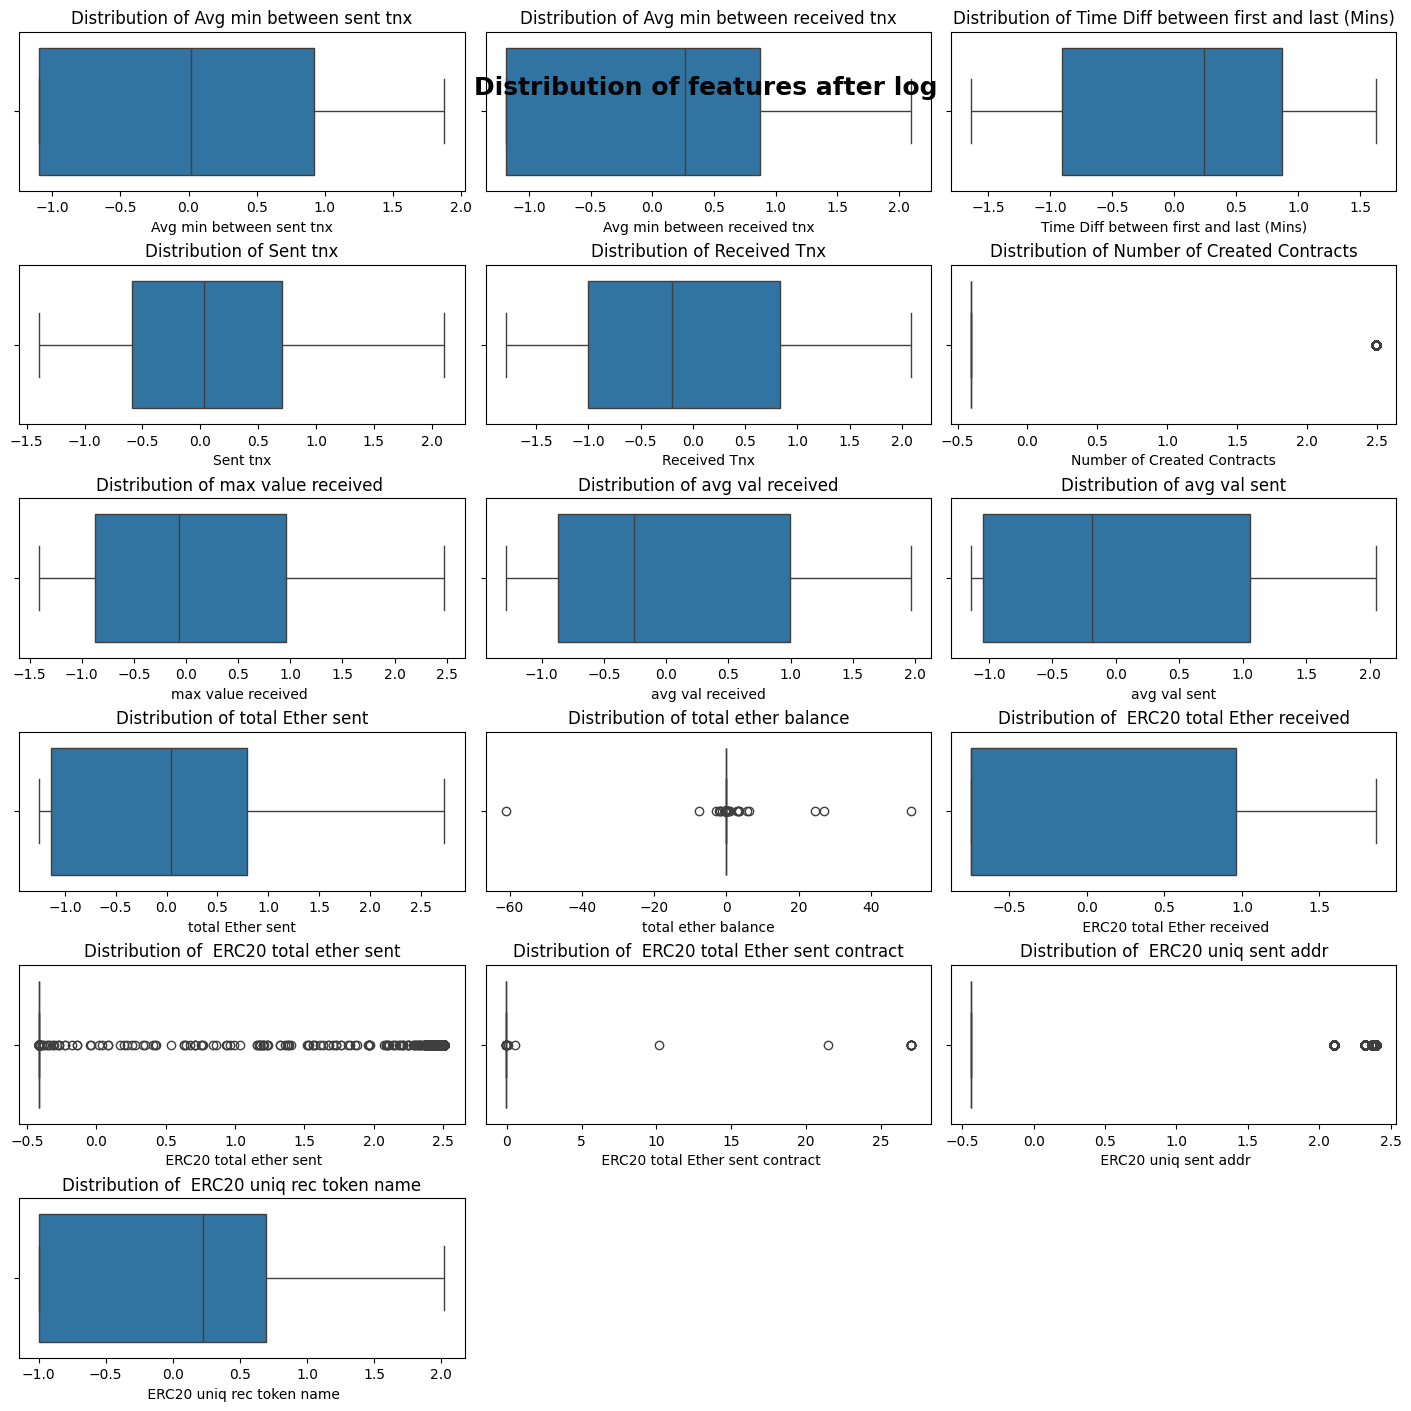

In [ ]:
# Distribution of features after log transformation

b=20

fig, axes = plt.subplots(6, 3, figsize=(14, 14), constrained_layout =True)
plt.subplots_adjust(wspace = 0.5, hspace=0.8)
axes[-1, -1].axis('off') # hide axes
axes[-1, -2].axis('off') # hide axes
plt.suptitle("Distribution of features after log",y=0.95, family='Sherif', size=18, weight='bold')

ax = sns.boxplot(ax = axes[0,0], data=norm_df, x=norm_df.columns[0])
ax.set_title(f'Distribution of {norm_df.columns[0]}')

ax1 = sns.boxplot(ax = axes[0,1], data=norm_df, x=norm_df.columns[1])
ax1.set_title(f'Distribution of {norm_df.columns[1]}')

ax2 = sns.boxplot(ax = axes[0,2], data=norm_df, x=norm_df.columns[2])
ax2.set_title(f'Distribution of {norm_df.columns[2]}')

ax3 = sns.boxplot(ax = axes[1,0], data=norm_df, x=norm_df.columns[3])
ax3.set_title(f'Distribution of {norm_df.columns[3]}')

ax4 = sns.boxplot(ax = axes[1,1], data=norm_df, x=norm_df.columns[4])
ax4.set_title(f'Distribution of {norm_df.columns[4]}')

ax5 = sns.boxplot(ax = axes[1,2], data=norm_df, x=norm_df.columns[5])
ax5.set_title(f'Distribution of {norm_df.columns[5]}')

ax6 = sns.boxplot(ax = axes[2,0], data=norm_df, x=norm_df.columns[6])
ax6.set_title(f'Distribution of {norm_df.columns[6]}')

ax7 = sns.boxplot(ax = axes[2,1], data=norm_df, x=norm_df.columns[7])
ax7.set_title(f'Distribution of {norm_df.columns[7]}')

ax8 = sns.boxplot(ax = axes[2,2], data=norm_df, x=norm_df.columns[8])
ax8.set_title(f'Distribution of {norm_df.columns[8]}')

ax9 = sns.boxplot(ax = axes[3,0], data=norm_df, x=norm_df.columns[9])
ax9.set_title(f'Distribution of {norm_df.columns[9]}')

ax10 = sns.boxplot(ax = axes[3,1], data=norm_df, x=norm_df.columns[10])
ax10.set_title(f'Distribution of {norm_df.columns[10]}')

ax11 = sns.boxplot(ax = axes[3,2], data=norm_df, x=norm_df.columns[11])
ax11.set_title(f'Distribution of {norm_df.columns[11]}')

ax12 = sns.boxplot(ax = axes[4,0], data=norm_df, x=norm_df.columns[12])
ax12.set_title(f'Distribution of {norm_df.columns[12]}')

ax13 = sns.boxplot(ax = axes[4,1], data=norm_df, x=norm_df.columns[13])
ax13.set_title(f'Distribution of {norm_df.columns[13]}')

ax14 = sns.boxplot(ax = axes[4,2], data=norm_df, x=norm_df.columns[14])
ax14.set_title(f'Distribution of {norm_df.columns[14]}')

ax15 = sns.boxplot(ax = axes[5,0], data=norm_df, x=norm_df.columns[15])
ax15.set_title(f'Distribution of {norm_df.columns[15]}')

plt.show()

# Handling the imbalance
Oversampling using SMOTE

In [ ]:
oversample = SMOTE()
print(f'Shape of the training before SMOTE: {norm_train_f.shape, y_train.shape}')

x_tr_resample, y_tr_resample = oversample.fit_resample(norm_train_f, y_train)
print(f'Shape of the training after SMOTE: {x_tr_resample.shape, y_tr_resample.shape}')

Shape of the training before SMOTE: ((7872, 16), (7872,))
Shape of the training after SMOTE: ((12230, 16), (12230,))


In [ ]:
# Target distribution before SMOTE
non_fraud = 0
fraud = 0

for i in y_train:
  if i == 0:
    non_fraud +=1
  else:
    fraud +=1

# Target distribution after SMOTE
no = 0
yes = 1

for j in y_tr_resample:
  if j == 0:
    no +=1
  else:
    yes +=1


print(f'BEFORE OVERSAMPLING \n \tNon-frauds: {non_fraud} \n \tFauds: {fraud}')
print(f'AFTER OVERSAMPLING \n \tNon-frauds: {no} \n \tFauds: {yes}')

BEFORE OVERSAMPLING 
 	Non-frauds: 6115 
 	Fauds: 1757
AFTER OVERSAMPLING 
 	Non-frauds: 6115 
 	Fauds: 6116


# Modeling

## Logistic regression

In [ ]:
LR = LogisticRegression(random_state=42)
LR.fit(x_tr_resample, y_tr_resample)

# Transform test features
norm_test_f = norm.transform(X_test)

preds = LR.predict(norm_test_f)

In [ ]:
print(y_test.shape)
y_test.value_counts()

(1969,)


,count
FLAG,
0,1547
1,422


              precision    recall  f1-score   support

           0       0.97      0.89      0.92      1547
           1       0.68      0.89      0.77       422

    accuracy                           0.89      1969
   macro avg       0.82      0.89      0.85      1969
weighted avg       0.91      0.89      0.89      1969

[[1372  175]
 [  48  374]]


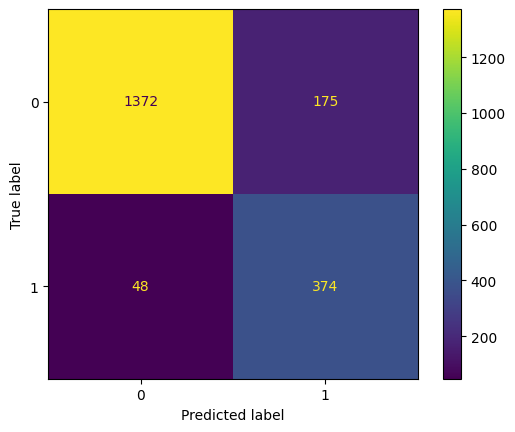

In [ ]:
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

# Calculate the confusion matrix
cm = confusion_matrix(y_test, preds)

# Create the ConfusionMatrixDisplay object with the confusion matrix and display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR.classes_)
# LR.classes_ provides the class labels for the display

disp.plot()


##RFC

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1547
           1       0.93      0.96      0.94       422

    accuracy                           0.98      1969
   macro avg       0.96      0.97      0.96      1969
weighted avg       0.98      0.98      0.98      1969

[[1517   30]
 [  18  404]]


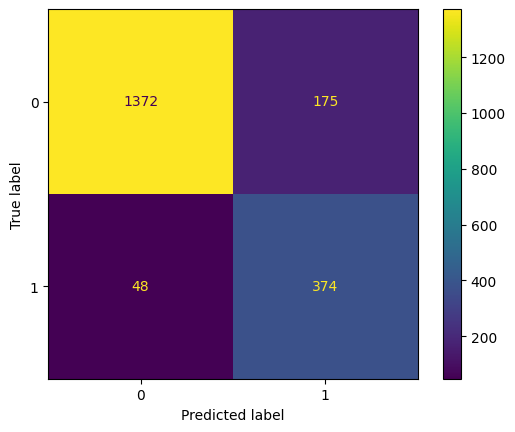

In [ ]:
RF = RandomForestClassifier(random_state=42)
RF.fit(x_tr_resample, y_tr_resample)
preds_RF = RF.predict(norm_test_f)

print(classification_report(y_test, preds_RF))
print(confusion_matrix(y_test, preds_RF))
# Create the ConfusionMatrixDisplay object with the confusion matrix and display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR.classes_)
# LR.classes_ provides the class labels for the display

disp.plot()

##XGB

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1547
           1       0.95      0.96      0.95       422

    accuracy                           0.98      1969
   macro avg       0.97      0.97      0.97      1969
weighted avg       0.98      0.98      0.98      1969

[[1525   22]
 [  17  405]]


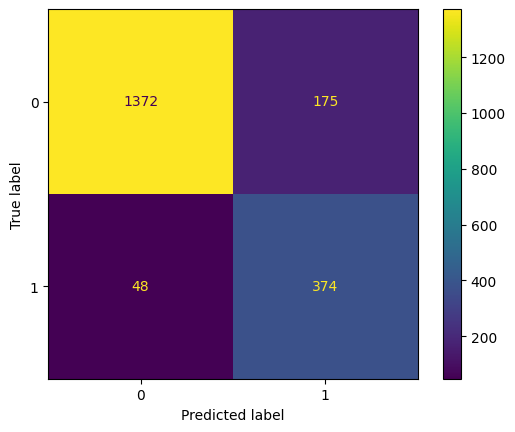

In [ ]:
xgb_c = xgb.XGBClassifier(seed=42)
xgb_c.fit(x_tr_resample, y_tr_resample)
preds_xgb = xgb_c.predict(norm_test_f)

print(classification_report(y_test, preds_xgb))
print(confusion_matrix(y_test, preds_xgb))
# Create the ConfusionMatrixDisplay object with the confusion matrix and display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR.classes_)
# LR.classes_ provides the class labels for the display

disp.plot()

#Hyper Parameter Tuning

In [ ]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.0 MB/s eta 0:00:00


In [ ]:
import optuna

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'subsample': trial.suggest_float('subsample', 0.3, 0.9),
        'max_depth': trial.suggest_int('max_depth', 2, 4),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.7),
    }
    model = XGBClassifier(**params)
    model.fit(x_tr_resample, y_tr_resample)
    return model.score(x_tr_resample, y_tr_resample)  # Adjust this based on recall if needed

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print(f"Best Params: {study.best_params}")

[I 2025-02-09 12:39:55,096] A new study created in memory with name: no-name-e506f53b-c422-42dd-8fe4-e4449940a509
[I 2025-02-09 12:39:56,233] Trial 0 finished with value: 0.9728536385936223 and parameters: {'learning_rate': 0.21010305685230377, 'n_estimators': 108, 'subsample': 0.5514332556306923, 'max_depth': 2, 'colsample_bytree': 0.5290577099478614}. Best is trial 0 with value: 0.9728536385936223.
[I 2025-02-09 12:40:00,038] Trial 1 finished with value: 0.9959116925592805 and parameters: {'learning_rate': 0.3342004808596923, 'n_estimators': 153, 'subsample': 0.7612112035864402, 'max_depth': 3, 'colsample_bytree': 0.36210272767313156}. Best is trial 1 with value: 0.9959116925592805.
[I 2025-02-09 12:40:01,694] Trial 2 finished with value: 0.9917416189697466 and parameters: {'learning_rate': 0.17236158284385844, 'n_estimators': 104, 'subsample': 0.8971734768822619, 'max_depth': 4, 'colsample_bytree': 0.3433796610159037}. Best is trial 1 with value: 0.9959116925592805.
[I 2025-02-09 12

Best Params: {'learning_rate': 0.424050805629554, 'n_estimators': 166, 'subsample': 0.6054790188065782, 'max_depth': 4, 'colsample_bytree': 0.6444374171142828}


              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1547
           1       0.93      0.96      0.95       422

    accuracy                           0.98      1969
   macro avg       0.96      0.97      0.97      1969
weighted avg       0.98      0.98      0.98      1969

[[1516   31]
 [  16  406]]


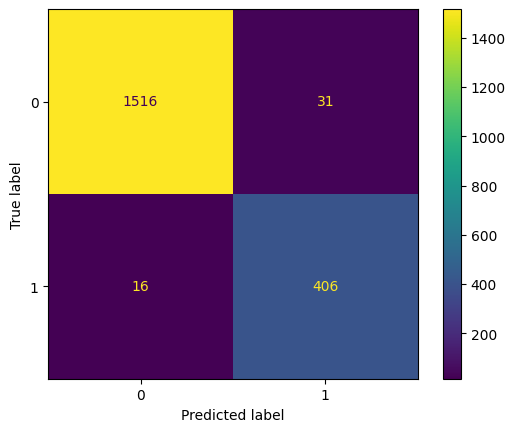

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Train the best XGBoost model using the best parameters found by Optuna
best_params = study.best_params  # Get best params from Optuna

best_xgb = XGBClassifier(**best_params)
best_xgb.fit(x_tr_resample, y_tr_resample)  # Train on resampled dataset

# Make predictions on test data
preds_best_xgb = best_xgb.predict(norm_test_f)

# Evaluate model performance
print(classification_report(y_test, preds_best_xgb))
cm = confusion_matrix(y_test, preds_best_xgb)
print(cm)

# Create and display the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_xgb.classes_)
disp.plot()


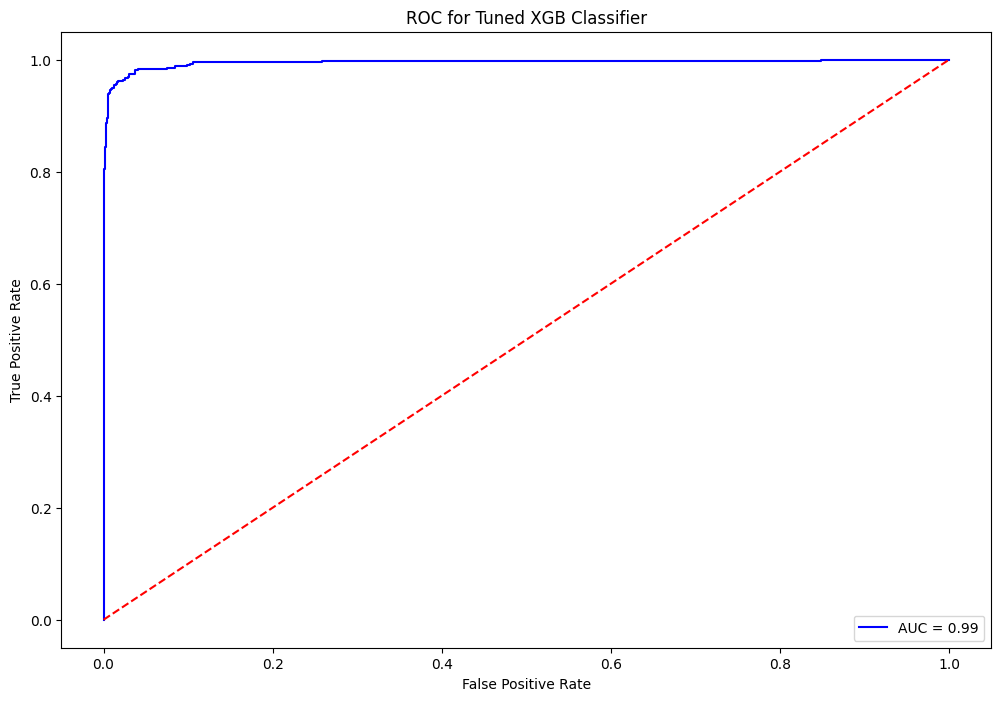

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the best hyperparameters from Optuna
best_params = study.best_params

# Train the best model
best_xgb = XGBClassifier(**best_params)
best_xgb.fit(x_tr_resample, y_tr_resample)  # Train on resampled dataset

# Get predicted probabilities
probs = best_xgb.predict_proba(norm_test_f)
pred = probs[:, 1]

# Compute ROC curve and AUC
fpr, tpr, threshold = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(12, 8))
plt.title('ROC for Tuned XGB Classifier')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal reference line
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [ ]:
import pickle

# Save the trained model
with open('model.pickle', 'wb') as pickle_out:
    pickle.dump(best_xgb, pickle_out)

print("Model saved successfully as model.pickle")

Model saved successfully as model.pickle
